MORDM OPTIMIZATION

In [1]:

from problem_formulation import get_model_for_problem_formulation
from ema_workbench import ema_logging, MultiprocessingEvaluator, Scenario, HypervolumeMetric, ScalarOutcome
from ema_workbench.em_framework.optimization import (ArchiveLogger, EpsilonProgress, to_problem)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

In [2]:
model, planning_steps = get_model_for_problem_formulation(2)

#The model requires a reference scenario to "kick-start"
reference_scenario = Scenario('reference', **{
    'discount rate 0': 1.5,
    'discount rate 1': 1.5,
    'discount rate 2': 1.5,
    'A.0_ID flood wave shape': 75,
    'A.1_Bmax': 240,
    'A.1_pfail': 0.25,
    'A.1_Brate': 10,
    'A.2_Bmax': 240,
    'A.2_pfail': 0.25,
    'A.2_Brate': 10,
    'A.3_Bmax': 240,
    'A.3_pfail': 0.25,
    'A.3_Brate': 10,
    'A.4_Bmax': 240,
    'A.4_pfail': 0.25,
    'A.4_Brate': 10,
    'A.5_Bmax': 240,
    'A.5_pfail': 0.25,
    'A.5_Brate': 10
})

In [3]:
convergence_metrics = [EpsilonProgress()]
nfe = 1000
epsilon = [0.5,0.5,0.5,0.01,0.01]
# Each epsilon value corresponds to a model outcome. The model outcomes are:
# expected damages, dike investment costs, rfr costs, evacuation cost, and casualties
# We select higher epsilon values to damages and costs, while we choose lower values for evacuation costs and casualties.

### Run the model using hypervolume and epsilon progress as the correct convergence metrics

In [4]:
convergence_metrics = [
    ArchiveLogger(
        "./MORDM_Data",
        [l.name for l in model.levers],
        [o.name for o in model.outcomes],
        base_filename="MORDM_HV_1.tar.gz",
    ),
    EpsilonProgress(),
]

with MultiprocessingEvaluator(model) as evaluator:
    optimization_result = evaluator.optimize(nfe=nfe, searchover='levers', epsilons=epsilon,  convergence=convergence_metrics,reference=reference_scenario)

[MainProcess/INFO] pool started with 10 workers
1099it [00:20, 52.61it/s]                                                      
[MainProcess/INFO] optimization completed, found 65 solutions
[MainProcess/INFO] terminating pool


In [5]:
#archives = ArchiveLogger.load_archives("./MORDM_Data/MORDM_HV_1.tar.gz")

In [6]:
#reference_set = results
#problem = to_problem(model, searchover="levers")

#hv = HypervolumeMetric(reference_set, problem)

#hypervolume = [(nfe, hv.calculate(archive)) for nfe, archive in archives.items()]
#hypervolume.sort(key=lambda x:x[0])
#hypervolume = np.asarray(hypervolume)

Plotting epsilon progress

In [7]:
#fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
#ax1.plot(convergence.nfe, convergence.epsilon_progress)
#ax1.set_ylabel('$\epsilon$-progress')
#ax2.plot(hypervolume[:, 0], hypervolume[:, 1])
#ax2.set_ylim(ymin=0)
#ax2.set_ylabel('hypervolume')

#ax1.set_xlabel('number of function evaluations')
#ax2.set_xlabel('number of function evaluations')
#plt.show()

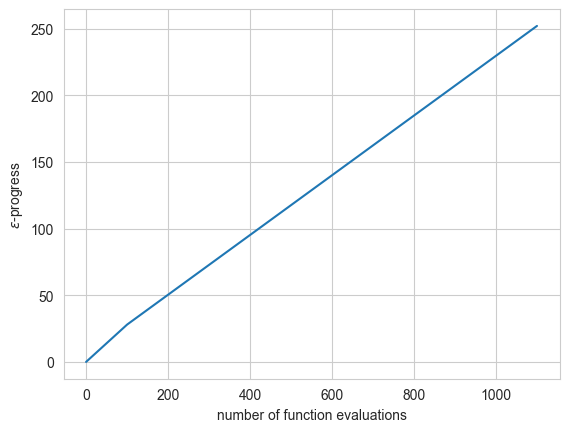

In [8]:
result, convergence = optimization_result

fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

Plotting the initial pool of solutions

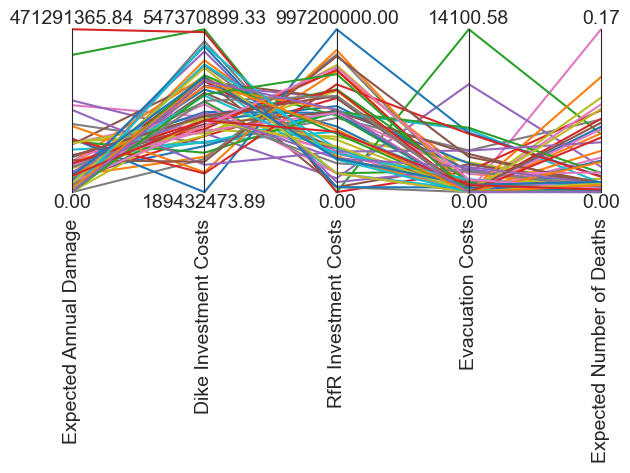

In [9]:
from ema_workbench.analysis import parcoords

data = result.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

Filtering the found solutions to those that are most important for the Delta Commission.
Deaths should not exceed 0.001 for the entire territory, as well as adaptability measured in the form of a continuous set of measures that in the long run make sense (e.g., not following dike heightening with RfR to avoid losing the investment of the first timestep)

In [10]:
# Select only those policies that result in an acceptable # of deaths
archive_allowable_deaths = result[result['Expected Number of Deaths'] < 0.001]
archive_allowable_deaths

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,Expected Annual Damage,Dike Investment Costs,RfR Investment Costs,Evacuation Costs,Expected Number of Deaths
4,0,0,0,0,1,0,1,0,0,0,...,5,0,6,0,0,1.073083e+07,4.399888e+08,248500000.0,435.655321,0.000927
11,0,0,0,1,0,0,0,0,0,0,...,2,4,7,4,5,1.747224e+06,4.792928e+08,217800000.0,6.675049,0.000309
17,0,0,0,0,0,0,0,0,1,0,...,0,1,5,1,5,0.000000e+00,5.212893e+08,30700000.0,0.000000,0.000000
22,0,0,0,0,0,0,1,1,1,1,...,2,5,5,2,1,1.401732e+06,4.334777e+08,469400000.0,59.103897,0.000081
24,0,1,1,0,0,0,0,0,1,0,...,7,6,6,6,2,0.000000e+00,4.235700e+08,577200000.0,0.000000,0.000000
25,1,0,0,0,1,0,0,0,1,0,...,3,3,3,1,3,7.053390e+05,4.322799e+08,575500000.0,23.462223,0.000114
27,0,0,0,0,1,1,1,0,0,0,...,7,1,7,0,5,0.000000e+00,2.621158e+08,843600000.0,0.000000,0.000000
37,1,0,1,0,0,0,0,0,1,0,...,1,2,4,5,2,1.854575e+07,4.679177e+08,199900000.0,993.384498,0.000829
38,1,0,1,0,0,0,0,0,1,0,...,4,2,3,2,0,1.677977e+06,3.538519e+08,321100000.0,65.868673,0.000135
39,0,0,1,0,0,0,0,1,1,0,...,2,5,4,5,1,0.000000e+00,4.703763e+08,267200000.0,0.000000,0.000000


In [11]:
# Remove columns for outcomes from the dataframe, resulting in a df of polcies
policies = archive_allowable_deaths.drop([o.name for o in model.outcomes], axis=1)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
4,0,0,0,0,1,0,1,0,0,0,...,6,7,2,2,7,5,0,6,0,0
11,0,0,0,1,0,0,0,0,0,0,...,0,10,6,0,7,2,4,7,4,5
17,0,0,0,0,0,0,0,0,1,0,...,5,5,2,4,5,0,1,5,1,5
22,0,0,0,0,0,0,1,1,1,1,...,2,4,1,5,2,2,5,5,2,1
24,0,1,1,0,0,0,0,0,1,0,...,0,8,5,1,6,7,6,6,6,2
25,1,0,0,0,1,0,0,0,1,0,...,0,3,7,4,5,3,3,3,1,3
27,0,0,0,0,1,1,1,0,0,0,...,0,9,1,0,5,7,1,7,0,5
37,1,0,1,0,0,0,0,0,1,0,...,2,4,0,6,1,1,2,4,5,2
38,1,0,1,0,0,0,0,0,1,0,...,1,9,4,0,3,4,2,3,2,0
39,0,0,1,0,0,0,0,1,1,0,...,1,5,3,4,6,2,5,4,5,1


Plot the smaller set of solutions that comply with the constraints.

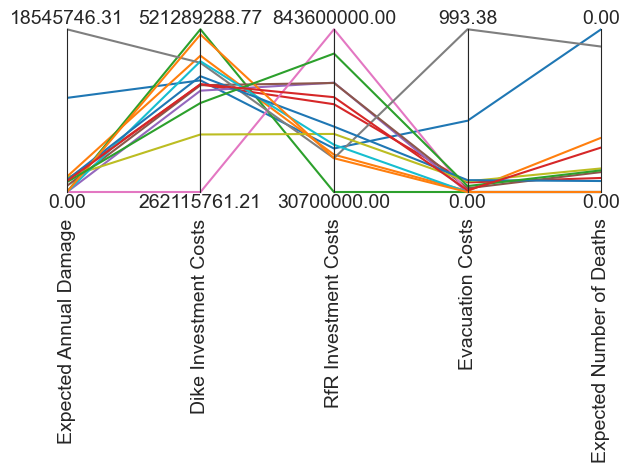

In [12]:
from ema_workbench.analysis import parcoords

data = archive_allowable_deaths.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

We should say something about the trade-offs that we found on the small set of solutions. For instance, sacrificing costs for lower deaths or costs for RfR as a measure of adaptability...
I think here would be very interesting to say something about the model and the constraints it was of the evaluation of RfR. Only one type (although there are many), and checking the water level only in winter (which is a good thing for the transport company to have RfR because when there are droughts they cannot pass anyways)

Re-evaluate candidate solutions under uncertainty

In [13]:
policies
from ema_workbench import Policy

policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))

** 1000 scenarios for each of the policy options.

In [14]:
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started with 10 workers
[MainProcess/INFO] performing 1000 scenarios * 14 policies * 1 model(s) = 14000 experiments
100%|████████████████████████████████████| 14000/14000 [04:18<00:00, 54.22it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [15]:
experiments, outcomes = results

In [16]:
experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario,policy,model
0,12,84.980447,10.0,0.231986,88.536919,1.5,0.945892,320.304477,1.0,0.551611,...,2,7,5,0,6,0,0,0,4,dikesnet
1,42,231.338458,1.0,0.813183,121.829891,1.5,0.530746,345.767413,1.0,0.819937,...,2,7,5,0,6,0,0,1,4,dikesnet
2,96,313.359044,10.0,0.929493,164.209009,1.5,0.244320,174.825563,10.0,0.339547,...,2,7,5,0,6,0,0,2,4,dikesnet
3,97,93.245535,10.0,0.589766,69.349138,1.5,0.034075,100.491440,1.0,0.395949,...,2,7,5,0,6,0,0,3,4,dikesnet
4,107,151.776782,1.0,0.177367,308.779684,10.0,0.781054,232.967572,10.0,0.745383,...,2,7,5,0,6,0,0,4,4,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,94,252.445364,10.0,0.430007,125.903867,10.0,0.438838,66.760703,1.0,0.780114,...,1,6,7,4,7,0,6,995,64,dikesnet
13996,108,199.113939,1.0,0.463282,189.357621,10.0,0.689533,63.147411,1.5,0.872446,...,1,6,7,4,7,0,6,996,64,dikesnet
13997,1,82.135607,1.0,0.844633,134.442010,1.5,0.535519,34.883645,1.5,0.646605,...,1,6,7,4,7,0,6,997,64,dikesnet
13998,81,56.369250,1.5,0.453053,171.803441,1.0,0.232861,299.348091,10.0,0.320410,...,1,6,7,4,7,0,6,998,64,dikesnet


In [17]:
outcomes

{'Expected Annual Damage': array([       0.        ,        0.        , 14098632.95228422, ...,
               0.        ,  1999500.28988469,        0.        ]),
 'Dike Investment Costs': array([4.39988806e+08, 4.39988806e+08, 4.39988806e+08, ...,
        4.33937672e+08, 4.33937672e+08, 4.33937672e+08]),
 'RfR Investment Costs': array([2.485e+08, 2.485e+08, 2.485e+08, ..., 5.046e+08, 5.046e+08,
        5.046e+08]),
 'Evacuation Costs': array([  0.        ,   0.        , 896.84679179, ...,   0.        ,
         63.6302356 ,   0.        ]),
 'Expected Number of Deaths': array([0.        , 0.        , 0.00192036, ..., 0.        , 0.00086282,
        0.        ])}

### SCENARIO DISCOVERY

In [18]:
#CLEAN NAMES TO FACILITATE PRIM
#Only leave the aggregated values (outcomes
experiments_noDI = experiments.drop(labels=['A.1_DikeIncrease 0','A.1_DikeIncrease 1','A.1_DikeIncrease 2','A.2_DikeIncrease 0','A.2_DikeIncrease 1','A.2_DikeIncrease 2','A.3_DikeIncrease 0','A.3_DikeIncrease 1','A.3_DikeIncrease 2','A.4_DikeIncrease 0','A.4_DikeIncrease 1','A.4_DikeIncrease 2','A.5_DikeIncrease 0','A.5_DikeIncrease 1','A.5_DikeIncrease 2', 'policy'], axis =1)
cleaned_experiments = experiments_noDI.drop(labels=['0_RfR 0','0_RfR 1','0_RfR 2','1_RfR 0','1_RfR 1','1_RfR 2','2_RfR 0','2_RfR 1','2_RfR 2','3_RfR 0','3_RfR 1','3_RfR 2','4_RfR 0','4_RfR 1','4_RfR 2','EWS_DaysToThreat'], axis =1)

In [19]:
cleaned_experiments

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,model
0,12,84.980447,10.0,0.231986,88.536919,1.5,0.945892,320.304477,1.0,0.551611,...,1.5,0.788953,45.495397,1.5,0.621492,4.5,2.5,4.5,0,dikesnet
1,42,231.338458,1.0,0.813183,121.829891,1.5,0.530746,345.767413,1.0,0.819937,...,1.5,0.161560,94.839498,10.0,0.522033,1.5,4.5,4.5,1,dikesnet
2,96,313.359044,10.0,0.929493,164.209009,1.5,0.244320,174.825563,10.0,0.339547,...,1.5,0.652628,255.336777,1.5,0.626396,4.5,2.5,2.5,2,dikesnet
3,97,93.245535,10.0,0.589766,69.349138,1.5,0.034075,100.491440,1.0,0.395949,...,1.0,0.933387,245.059125,10.0,0.795273,3.5,3.5,1.5,3,dikesnet
4,107,151.776782,1.0,0.177367,308.779684,10.0,0.781054,232.967572,10.0,0.745383,...,10.0,0.437713,58.102020,1.0,0.111807,2.5,3.5,3.5,4,dikesnet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,94,252.445364,10.0,0.430007,125.903867,10.0,0.438838,66.760703,1.0,0.780114,...,10.0,0.849252,225.076272,1.5,0.237430,4.5,1.5,3.5,995,dikesnet
13996,108,199.113939,1.0,0.463282,189.357621,10.0,0.689533,63.147411,1.5,0.872446,...,1.0,0.160510,275.073809,1.0,0.325245,1.5,2.5,2.5,996,dikesnet
13997,1,82.135607,1.0,0.844633,134.442010,1.5,0.535519,34.883645,1.5,0.646605,...,1.5,0.220402,336.645513,1.5,0.901177,4.5,3.5,1.5,997,dikesnet
13998,81,56.369250,1.5,0.453053,171.803441,1.0,0.232861,299.348091,10.0,0.320410,...,10.0,0.689750,169.673552,1.0,0.850418,3.5,1.5,2.5,998,dikesnet


In [20]:
from ema_workbench.analysis import prim
from ema_workbench import ema_logging
ema_logging.log_to_stderr(ema_logging.INFO);

x = cleaned_experiments

y = (outcomes['Expected Number of Deaths'] <= 0.001)
print(y)
prim_alg = prim.Prim(x,y, threshold = 0.5, peel_alpha = 0.01)
box = prim_alg.find_box()

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 14000 points remaining, containing 8342 cases of interest


[ True  True False ...  True  True  True]


[MainProcess/INFO] mean: 1.0, mass: 0.087, coverage: 0.1460081515224167, density: 1.0 restricted_dimensions: 11


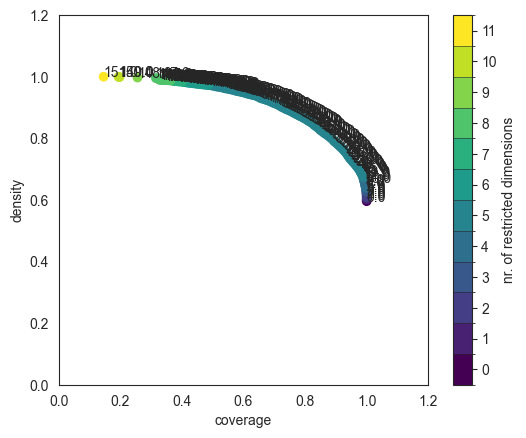

In [21]:
box.show_tradeoff(annotated=True)
plt.show()

here we have to talk about the trade-offs between density and coverage.

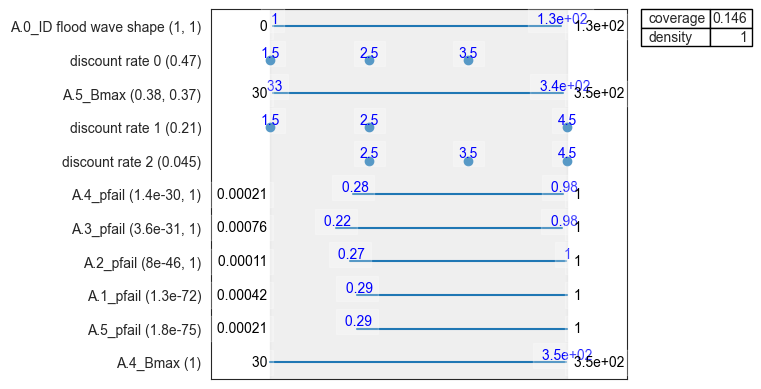

In [22]:
box.inspect(style='graph')
plt.show()

Bmax is not relevant for deaths. High pfail is correlated with higher deaths.
This only cover 16% of the cases of interests with a density of 1. It is not very conclusive, PRIM had issues explaining the problem without restricting a significant number of dimensions (in the case of this image but once we run the final probably that changes)
PRIM will always suffer a bit because the problem is not linear.

Use dimensional stacking to see if we can conclude something else

In [23]:
from ema_workbench.analysis import dimensional_stacking

Blank spaces mean that additional runs are needed for the coverage to increase and get conclusive results.

[MainProcess/INFO] model dropped from analysis because only a single category


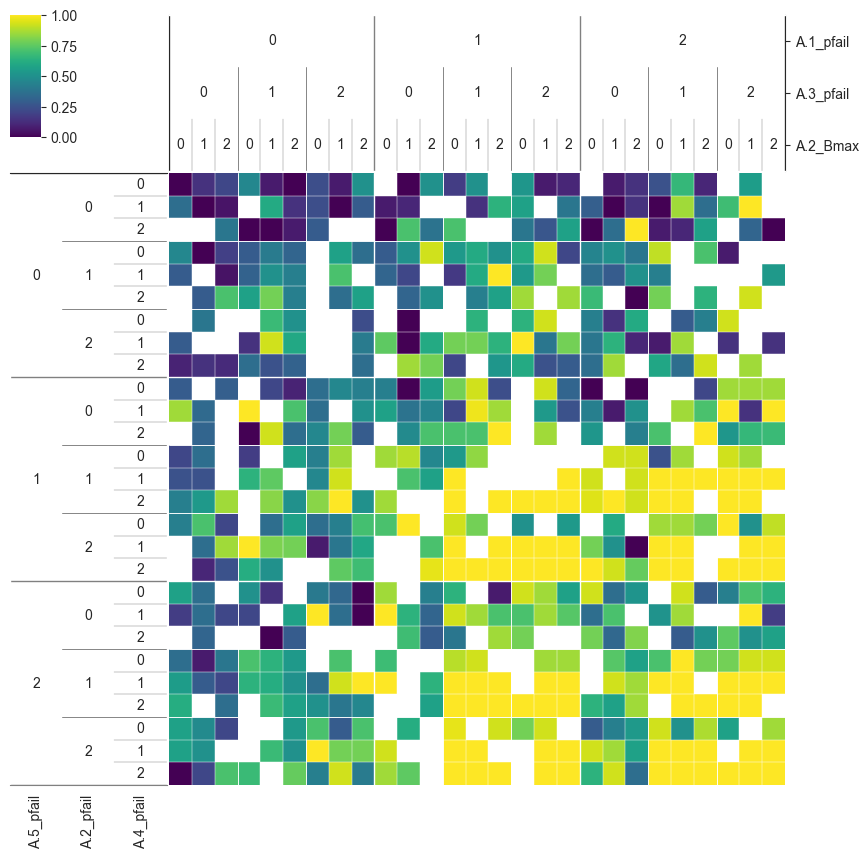

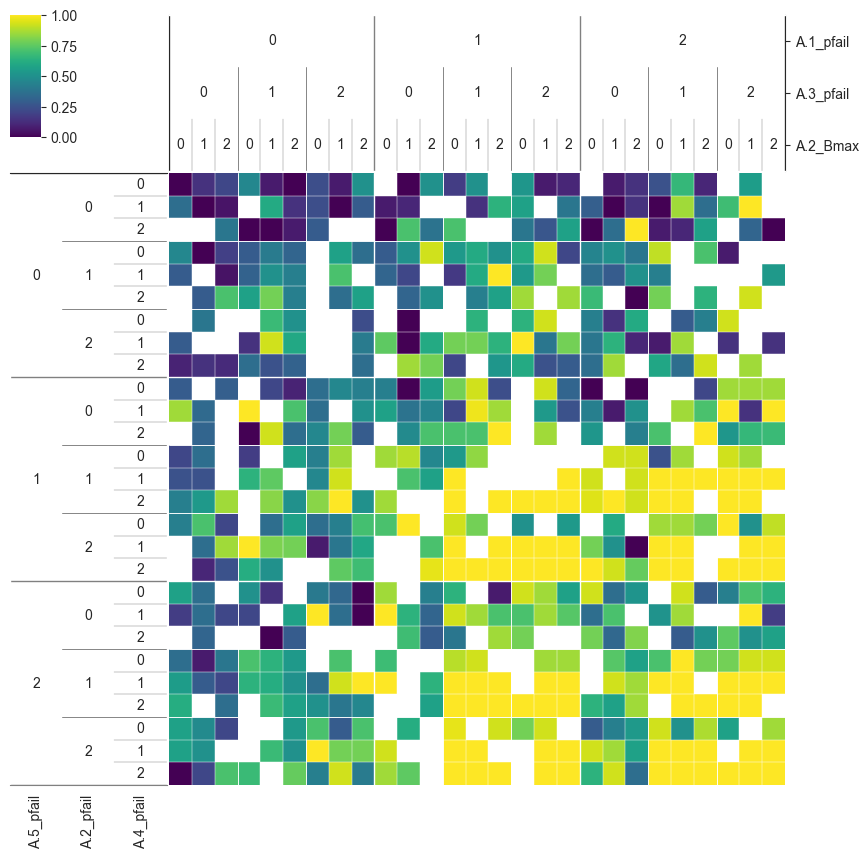

In [24]:
dimensional_stacking.create_pivot_plot(cleaned_experiments, y)

We will choose a point in the lower 25% (around 0.7 density and 0.7 coverage)

coverage     0.900024
density      0.786343
id          36.000000
mass         0.682000
mean         0.786343
res_dim      5.000000
Name: 36, dtype: float64

             box 36                                 
                min       max      qp value qp value
A.5_pfail  0.100696  0.999559  2.815522e-43      NaN
A.1_pfail  0.097941  0.999525  7.777149e-33      NaN
A.2_pfail  0.090252  0.999612  2.338798e-24      NaN
A.3_pfail  0.053134  0.999397  4.909026e-10      NaN
A.4_pfail  0.033975  0.999330  2.157275e-05      NaN



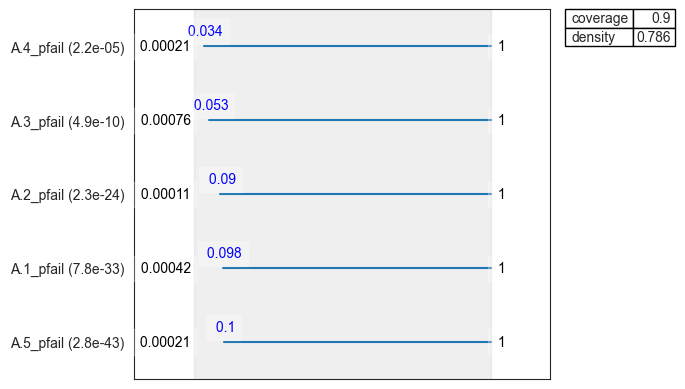

In [25]:
point = 36
box.inspect(point)
box.inspect(point, style='graph')
plt.show()

Again this is not conclusive, except to say that pfail is importaint but not that one on dike ring 3.
We will resample another point in the upper 75%.

In [27]:
print(box)

In [28]:
box.resample(point)

[MainProcess/INFO] resample 4
[MainProcess/INFO] resample 5
[MainProcess/INFO] resample 6
[MainProcess/INFO] resample 7
[MainProcess/INFO] resample 8
[MainProcess/INFO] resample 9


,reproduce coverage,reproduce density
A.1_pfail,100.0,100.0
A.2_pfail,100.0,100.0
A.3_pfail,100.0,100.0
A.4_pfail,100.0,100.0
A.5_pfail,100.0,100.0
A.0_ID flood wave shape,0.0,0.0
A.1_Bmax,0.0,0.0
A.1_Brate,0.0,0.0
A.2_Bmax,0.0,0.0
A.2_Brate,0.0,0.0


Scatter plot to visually understand the PRIM PROCESS

In [ ]:
print(len(box.box_lims))

box.select(140)
box.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.savefig('scatter plots.png')
plt.show()

The figure proves that PRIM might not be the best approach, and an alternative to scenario discovery should be explored.

### Sensitivity analysis using extra trees
Extra trees is less computational-intensive than Sobol. We will use the feature score to understand which of the uncertain values have the highest effect in the outcomes of the model.

In [ ]:
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
import pandas as pd

In [ ]:
final_outcomes = outcomes['Expected Number of Deaths']

In [ ]:
final_outcomes

In [ ]:
deaths_mean = np.mean(outcomes['Expected Number of Deaths'])

we use the outcome of expected number of deaths as our prime indicator.

calculating the scores

In [ ]:
scores = feature_scoring.get_ex_feature_scores(cleaned_experiments, final_outcomes,
                                      max_features=0.6, mode=RuleInductionType.REGRESSION)[0]
scores

Create the plot

In [ ]:
fig, ax = plt.subplots(1)

scores.T.plot(ax=ax)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Samples')
ax.set_ylabel('feature scores')
plt.show()

### ROBUSTNESS METRICS
1. SIGNAL TO NOISE RATIO. Function defined as assignment 9

In [ ]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [ ]:
experiments, outcomes = results

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}

    logical = experiments['policy'] == policy

    for outcome in model.outcomes:
        value = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

In [ ]:
from ema_workbench.analysis import parcoords

data = scores
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)

plt.show()

2. Maximum regret. The code is as the model answer for assignment 9.

In [ ]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [ ]:
experiments, outcomes = results

overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']

    # create a DataFrame with all the relevant information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name],
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')

    # flatten the resulting hierarchical index resulting from
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()

    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

In [ ]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

In [ ]:
import matplotlib
cmap = matplotlib.colormaps['Spectral']
colors = [cmap(x/(data.shape[0] - 1)) for x in range(data.shape[0])]

data = max_regret

limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i % len(colors)])
paraxes.legend()

plt.show()

In [ ]:
from collections import defaultdict

policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

In [ ]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=2, figsize=(10,5),
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this.


# zip allows us to zip together the list of axes and the list of
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    sns.boxplot(data=data, ax=ax)

    # removes top and left hand black outline of axes
    sns.despine()

    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()